# EMA context exploration

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


## Notebook setup

### Imports

In [372]:
%matplotlib inline

# base utilities
import os
import pickle
import random

# data manipulation
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_ind

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, display_html

# user imports
from utils.process_data import *
from utils.stats import *

# rpy 
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
lmtest = importr('lmtest')
Hmisc = importr("Hmisc")
pandas2ri.activate()

### JS scripts

In [10]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [9]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

### Display

In [126]:
sns.set_palette(sns.color_palette('colorblind'))

## Sandbox

### Build data

In [37]:
timezones = pd.read_csv('CS120/timezones.csv', sep='\t', header=None, 
                       names=['pid', 'offset'])
tz_dict = timezones.set_index('pid').to_dict()['offset']
timezones.head()

,pid,offset
0,EW057EV,-5.0
1,MQ077WG,-5.0
2,1203725,-8.0
3,BD921DW,-5.0
4,1573207,-5.0


In [50]:
pid = '1183252'
emm_cols = ['stress', 'mood', 'energy', 'focus']

emm_test = pd.read_csv(csv_files['emm'].format(pid), sep='\t', header=None,
                      names=csv_headers['emm'])
print(emm_test.shape)
emm_test = emm_test.drop_duplicates()
print(emm_test.shape)
print(emm_test['stress'].describe())
emm_test['time'] = pd.to_datetime(emm_test['timestamp'], unit='s')
emm_test['time'] = emm_test.apply(lambda x: x.time + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)

emm_test['date'] = pd.DatetimeIndex(emm_test['time']).normalize()

for col in emm_cols:
    emm_test = z_score(emm_test, col)
    
display(emm_test.loc[emm_test['date'] >= '2015-11-23'])

(151, 5)
(148, 5)
count    148.000000
mean       5.641892
std        0.495011
min        4.000000
25%        5.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: stress, dtype: float64


,timestamp,stress,mood,energy,focus,time,date
78,1.448306e+09,-1.296723,-1.296723,-1.296723,-1.296723,2015-11-23 14:10:51,2015-11-23
79,1.448329e+09,-1.296723,-1.296723,-1.296723,-1.296723,2015-11-23 20:37:47,2015-11-23
80,1.448392e+09,0.723435,0.723435,0.723435,0.723435,2015-11-24 14:00:06,2015-11-24
82,1.448392e+09,0.723435,0.723435,0.723435,0.723435,2015-11-24 14:00:36,2015-11-24
84,1.448415e+09,-1.296723,-1.296723,-1.296723,-1.296723,2015-11-24 20:37:52,2015-11-24
85,1.448469e+09,-1.296723,-1.296723,-1.296723,-1.296723,2015-11-25 11:37:23,2015-11-25
87,1.448480e+09,0.723435,0.723435,0.723435,0.723435,2015-11-25 14:35:16,2015-11-25
88,1.448503e+09,0.723435,0.723435,0.723435,0.723435,2015-11-25 21:02:06,2015-11-25
89,1.448557e+09,0.723435,0.723435,0.723435,0.723435,2015-11-26 11:52:47,2015-11-26
90,1.448569e+09,0.723435,0.723435,0.723435,0.723435,2015-11-26 15:23:37,2015-11-26


In [414]:
# build the DataFrame

def z_score(df, in_col):
    """
    computes the z-score of the given column
    """
    df['z_' + in_col] = (df[in_col] - df[in_col].mean()) / df[in_col].std()
    return df

def process_emm(pid, unit='s'):
    """Processes the given participants's emm.csv file.
    
    Adds date (correcting for timezone), pid columns and standardization columns.
    
    Args:
        emm_df (pandas.DataFrame): the raw emm_df loaded from csv
        pid (str): the participant id
    
    Returns:
        pandas.Dataframe: converted Dataframe with columns: [pid, timestamp, stress, mood, energy, focus, time, date]
    """
    emm_cols = ['stress', 'mood', 'energy', 'focus']
    emm_df = pd.read_csv(csv_files['emm'].format(pid), sep='\t', header=None,
                      names=csv_headers['emm'])
    emm_df = emm_df.drop_duplicates()
    emm_df['time'] = pd.to_datetime(emm_df['timestamp'], unit=unit)
    emm_df['time'] = emm_df.apply(lambda x: x.time + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)

    emm_df['date'] = pd.DatetimeIndex(emm_df['time']).normalize()
    emm_df['pid'] = pid
  
    for col in emm_cols:
        emm_df = z_score(emm_df, col)
    
    return emm_df

In [415]:
pid = '1496251'
test_df = process_emm(pid, unit='s')

In [416]:
test_df.head()

,timestamp,stress,mood,energy,focus,time,date,pid,z_stress,z_mood,z_energy,z_focus
0,1.446048e+09,7,3,2,4,NaT,NaT,1496251,0.665192,-1.085911,-1.442773,-0.656733
1,1.446055e+09,7,1,1,5,NaT,NaT,1496251,0.665192,-2.471383,-2.280148,0.027749
2,1.446080e+09,7,5,6,5,NaT,NaT,1496251,0.665192,0.299562,1.906724,0.027749
3,1.446135e+09,7,2,1,4,NaT,NaT,1496251,0.665192,-1.778647,-2.280148,-0.656733
4,1.446143e+09,7,5,4,7,NaT,NaT,1496251,0.665192,0.299562,0.231975,1.396714


In [420]:
# process all participants
emm_df = pd.DataFrame()
#id_dirs.remove('1496251') # missing timezone data
for pid in id_dirs:
        csv_path = csv_files['emm'].format(pid)
        if os.path.exists(csv_path):
            df = process_emm(pid)
            emm_df = emm_df.append(df)
            print(pid)

1579481
1425272
984221
1145713
HE593LT
1564420
1521517
FJ227MJ
1041667
1213535
1255682
489868
1184498
1097633
TP903SN
QG620BT
1433908
555220
BD921DW
1155329
UQ050PR
CB832WW
1503395
1367477
1229114
919141
1294671
JB320SW
913164
1374066
WT253RB
DB233EI
1560782
1569370
SP157RF
1124659
1401811
1428949
1126438
1128660
564447
1288818
1157796
1307868
1078563
CL263NI
39468
1199841
1327952
HU113HP
BJ540PT
636646
97397
1495360
1569348
1479464
1299151
1578395
1178484
1559190
1497026
575209
1567871
1219403
1208813
820387
1142152
1571376
1130955
1403756
1114936
1051651
1505268
1531633
1270329
1210517
1422927
98384
1197009
871322
1170978
1130163
EW057EV
345921
662410
1550259
NJ280ID
1207041
MQ077WG
1515656
1143410
1444502
IQ300QN
1213494
XF600QF
1225160
1165040
AC363GY
1328707
1217425
619634
1305690
1027472
606449
1307899
616751
1385032
1164303
1041304
1234088
1409046
1084240
506107
1334243
1186533
411896
1022235
1079411
1055808
1179075
106743
1495049
1537431
831987
1439160
391378
1380734
1177977
11

In [421]:
#pickle.dump(emm_df, open("pkl/std_emm.df", "wb"), -1)
pickle.dump(emm_df, open("pkl/emm.df", "wb"), -1)

In [422]:
#emm_df = pickle.load(open("pkl/std_emm.df", "rb"))

In [423]:
screener_df = get_screener_df()
group_cols = ['CONTROL', 'ANXIOUS', 'DEPRESSED', 'DEPRESSED_ANXIOUS'] 
screener_df[group_cols] = screener_df[group_cols].fillna(0)

def group_map(row):
    if row['ANXIOUS'] == 1:
        return 'anxious'
    if row['CONTROL'] == 1:
        return 'control'
    if row['DEPRESSED'] == 1:
        return 'depressed'
    if row['DEPRESSED_ANXIOUS'] == 1:
        return 'depressed_anxious'


screener_df['group'] = screener_df.apply(group_map, axis=1)

In [424]:
screener_df.head()

,pid,score_PHQ,score_GAD,CONTROL,ANXIOUS,DEPRESSED,DEPRESSED_ANXIOUS,group
0,25349,6,10,0.0,1.0,0.0,0.0,anxious
1,38880,5,13,0.0,1.0,0.0,0.0,anxious
2,39468,12,11,0.0,0.0,0.0,1.0,depressed_anxious
3,62977,2,1,1.0,0.0,0.0,0.0,control
4,97397,20,9,0.0,0.0,1.0,0.0,depressed


In [425]:
emm_df = emm_df.merge(screener_df, on='pid', how='left')

In [426]:
control_emm = emm_df.loc[emm_df['CONTROL'] == 1]
print(control_emm.drop_duplicates('pid').shape[0])

anxious_emm = emm_df.loc[emm_df['ANXIOUS'] == 1]
print(anxious_emm.drop_duplicates('pid').shape[0])

depress_emm = emm_df.loc[emm_df['DEPRESSED'] == 1]
print(depress_emm.drop_duplicates('pid').shape[0])

dep_anx_emm = emm_df.loc[emm_df['DEPRESSED_ANXIOUS'] == 1]
print(dep_anx_emm.drop_duplicates('pid').shape[0])

59
44
51
52


In [427]:
emm_df.loc[emm_df['date'] == '2015-12-02']['mood'].describe()

count    452.000000
mean       4.836283
std        1.756764
min        0.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        8.000000
Name: mood, dtype: float64

In [428]:
emm_df['hour'] = emm_df['time'].dt.hour + (emm_df['time'].dt.minute / 60)

In [429]:
emm_df['emm_idx'] = emm_df.groupby(['pid', 'date'], as_index=False).cumcount()

In [511]:
emm_df.head()

# builds a dict of lists for the dates with complete EMA responses (all 3)

complete_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
complete_dates = complete_dates.loc[complete_dates['emm_idx'] == 3]
complete_dates.head()
complete_date_dict = {k: list(v) for k,v in complete_dates.groupby('pid')['date']}

def check_date(row):
    """df.apply function to check for rows that are part of a complete day.
    """
    if  row['pid'] in complete_date_dict:
        return row['date'] in complete_date_dict[row['pid']]
    else:
        return False


complete_date_emm = emm_df[emm_df.apply(check_date, axis=1)]

In [512]:
# builds a dict of lists of tuples (date, # complete) for the dates with missing EMAs

temp_df = emm_df.drop_duplicates(subset=['pid', 'date'])
pids = emm_df['pid'].unique()

missing_date_dict = {}
total_days_dict = {}


for pid in pids:
    # figure out which dates have 0 EMA responses
    pid_dict = missing_date_dict.get(pid)
    if pid_dict is None:
        pid_dict = {}
        missing_date_dict[pid] = pid_dict
        
    pid_df = temp_df.loc[temp_df['pid'] == pid]
    
    # fill in all dates between the first and last date    
    idx = pd.date_range(pid_df['date'].min(), pid_df['date'].max())
    s = pid_df[['date', 'timestamp']].squeeze()
    s = s.set_index('date')
    s = s.reindex(idx, fill_value=np.nan)
    # count total number of days in the study
    total_days_dict[pid] = s.shape[0]
    
    # find which dates are missing
    missing_dates = s[s['timestamp'].isna()].index.values
    for date in missing_dates:
        pid_dict[date] = 0

assert len(total_days_dict) == len(pids)
        
# figure out which dates have < 3 EMA responses
missing_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
missing_dates = missing_dates.loc[missing_dates['emm_idx'] < 3]
pids = missing_dates['pid'].unique()

for pid in pids:
    pid_df = missing_dates.loc[missing_dates['pid'] == pid]
    pid_dict = missing_date_dict[pid]
    for _, row in pid_df.iterrows():
        # plus 1 because emm_idx is zero indexed, so we can count # responded EMAs
        pid_dict[row['date']] = row['emm_idx'] + 1
        


In [513]:
# old miss/total calculation
# temp_df = emm_df.groupby(['pid', 'date'], as_index=False)['stress'].count()
# miss_day_count = temp_df.groupby('pid')['stress'].apply(lambda x: x[x < 3].count())
# tot_day_count = emm_df.groupby('pid')['date'].nunique()

tot_day_count = pd.Series(data=total_days_dict)
tot_day_count = tot_day_count.rename_axis(index='pid')
miss_day_count = pd.Series(data={k: len(v) for k,v in missing_date_dict.items()})
miss_day_count = miss_day_count.rename_axis(index='pid')

#print(miss_day_count.head())

In [514]:
no_ema_count_dict = {}

for pid, date_dict in missing_date_dict.items():
    zero_count = 0
    for ts, num_emas in date_dict.items():
        if num_emas == 0:
            zero_count += 1
    no_ema_count_dict[pid] = zero_count
    
no_ema_count = pd.Series(data=no_ema_count_dict)
no_ema_count = no_ema_count.rename_axis(index='pid')

In [515]:
context_df = pd.DataFrame()
context_df['pct_missing_emm_days'] = miss_day_count / tot_day_count
context_df['pct_no_emm_days'] = no_ema_count / tot_day_count

context_df = context_df.reset_index()
context_df = context_df.merge(screener_df[['pid', 'group']], on='pid', how='left')
display(context_df.loc[context_df['pid'].isin(['1002060', '1579481', '1425272', '984221'])])

,pid,pct_missing_emm_days,pct_no_emm_days,group
0,1579481,0.068966,0.000000,depressed_anxious
1,1425272,0.216216,0.108108,depressed
2,984221,0.040000,0.020000,control
174,1002060,0.137931,0.000000,depressed_anxious


In [516]:
# get mean and variance of emm completion
complete_date_mean = complete_date_emm.groupby(['pid', 'emm_idx'])['hour'] \
                                        .mean() \
                                        .unstack(level=1) \
                                        .add_suffix("_mean_emm") \
                                        .reset_index()

complete_date_std = complete_date_emm.groupby(['pid', 'emm_idx'])['hour'] \
                                        .std() \
                                        .unstack(level=1) \
                                        .add_suffix("_std_emm") \
                                        .reset_index()

#display(complete_date_mean.head())
#display(complete_date_std.head())
display(complete_date_mood.head())
display(complete_date_z_mood.head())

emm_idx,pid,0_mean_mood,1_mean_mood,2_mean_mood
0,1002060,3.959184,4.020408,4.061224
1,1013558,5.770833,6.208333,5.937500
2,1022235,4.578947,4.578947,4.447368
3,1027472,5.951220,5.951220,6.024390
4,1041304,4.481481,4.740741,4.888889


emm_idx,pid,0_mean_z_mood,1_mean_z_mood,2_mean_z_mood
0,1002060,-0.023172,0.061679,0.118247
1,1013558,-0.121771,0.170146,-0.010565
2,1022235,0.060212,0.060212,-0.029056
3,1027472,-0.111757,-0.111757,0.034600
4,1041304,-0.283151,-0.014729,0.138655


In [517]:
# add emm scores by EMM response time
emm_cols  = ['mood', 'stress', 'focus', 'energy']

for emm in emm_cols:
    complete_date_mean_emm = complete_date_emm.groupby(['pid', 'emm_idx'])[emm] \
                                            .mean() \
                                            .unstack(level=1) \
                                            .add_suffix("_mean_" + emm) \
                                            .reset_index()

    complete_date_mean_z_emm = complete_date_emm.groupby(['pid', 'emm_idx'])["z_" + emm] \
                                            .mean() \
                                            .unstack(level=1) \
                                            .add_suffix("_mean_z_" + emm) \
                                            .reset_index()
    
    context_df = context_df.merge(complete_date_mean_emm, on='pid', how='left')
    context_df = context_df.merge(complete_date_mean_z_emm, on='pid', how='left')

In [518]:
context_df = context_df.merge(complete_date_mean, on='pid', how='left')
context_df = context_df.merge(complete_date_std, on='pid', how='left')

In [519]:
context_df.head()

,pid,pct_missing_emm_days,pct_no_emm_days,group,0_mean_mood,1_mean_mood,2_mean_mood,0_mean_z_mood,1_mean_z_mood,2_mean_z_mood,...,2_mean_energy,0_mean_z_energy,1_mean_z_energy,2_mean_z_energy,0_mean_emm,1_mean_emm,2_mean_emm,0_std_emm,1_std_emm,2_std_emm
0,1579481,0.068966,0.000000,depressed_anxious,4.862745,4.686275,5.098039,0.045390,-0.122478,0.269214,...,3.980392,-0.071721,0.072555,0.162728,9.415686,14.355556,20.930719,0.576574,0.327748,0.513435
1,1425272,0.216216,0.108108,depressed,4.321429,4.607143,4.678571,-0.245103,0.096692,0.182141,...,4.428571,-0.208587,-0.049424,0.348483,9.544048,14.763690,21.019643,2.262361,1.505559,1.060593
2,984221,0.040000,0.020000,control,4.645833,4.875000,5.125000,-0.185126,-0.016390,0.167685,...,4.166667,-0.167603,0.100971,0.011446,9.332292,14.542014,20.804861,1.113077,0.665930,0.563927
3,1145713,0.148148,0.000000,depressed,4.900000,4.925000,4.725000,0.035633,0.055994,-0.106898,...,3.025000,0.296649,0.406181,-0.269266,11.266667,14.524583,21.108750,1.355331,0.688561,0.932990
4,HE593LT,0.297297,0.000000,depressed,5.461538,6.346154,6.000000,-0.357958,0.241595,0.006987,...,3.038462,0.079635,0.456881,-0.333540,9.308333,14.957692,20.907051,0.364699,0.872738,0.311454


In [439]:
context_df['0_std_emm'].describe()

count    204.000000
mean       1.520810
std        1.201155
min        0.137455
25%        0.695995
50%        1.097343
75%        1.978779
max        5.766143
Name: 0_std_emm, dtype: float64

### Other sensor modalities

In [562]:
ems_raw =  process_csv_all_daily('ems', normalize=False)
ems_raw['sleep_amount'] = ems_raw['sleep_amount'] / (1000*60*60)
ems_raw['sleep_quality'] = ems_raw['sleep_quality'].astype(int)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Plots

### Functions

In [580]:
def build_emm_response_plot(target):
    """Builds plots for the target EMA response.
    """
    mpl.rcParams.update(mpl.rcParamsDefault)
    fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)

    for i in range(3):

        sns.catplot(x='group', 
                y="{}_mean_{}".format(i, target), 
                data=context_df, 
                kind="bar",
                ax=axes[i, 0])
        sns.catplot(x='group', 
                y="{}_mean_z_{}".format(i, target), 
                data=context_df, 
                kind="bar",
                ax=axes[i, 1])
        axes[i,0].set(ylim=(0, 7), ylabel="ema {} {}".format(i, target))
        axes[i,1].set(ylim=(-.2, .2), ylabel="ema {} z-{}".format(i, target))

    # needed for bug with catplot
    for i in range(2, 8):
        plt.close(i)
    plt.suptitle("{} EMA responses across groups and survey order".format(target), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    plt.show()

### Descriptive Stats

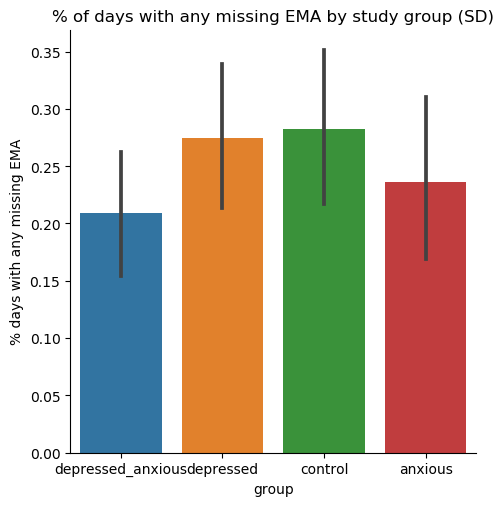

In [581]:
mpl.rcParams.update(mpl.rcParamsDefault)


sns.catplot(x='group', 
            y='pct_missing_emm_days', 
            data=context_df, 
            kind="bar")
plt.ylabel("% days with any missing EMA")
plt.title("% of days with any missing EMA by study group (SD)")
plt.show()

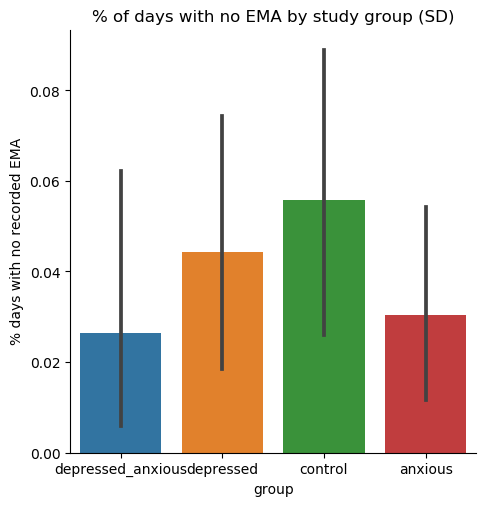

In [582]:
mpl.rcParams.update(mpl.rcParamsDefault)


sns.catplot(x='group', 
            y='pct_no_emm_days', 
            data=context_df, 
            kind="bar")
plt.ylabel("% days with no recorded EMA")
plt.title("% of days with no EMA by study group (SD)")
plt.show()

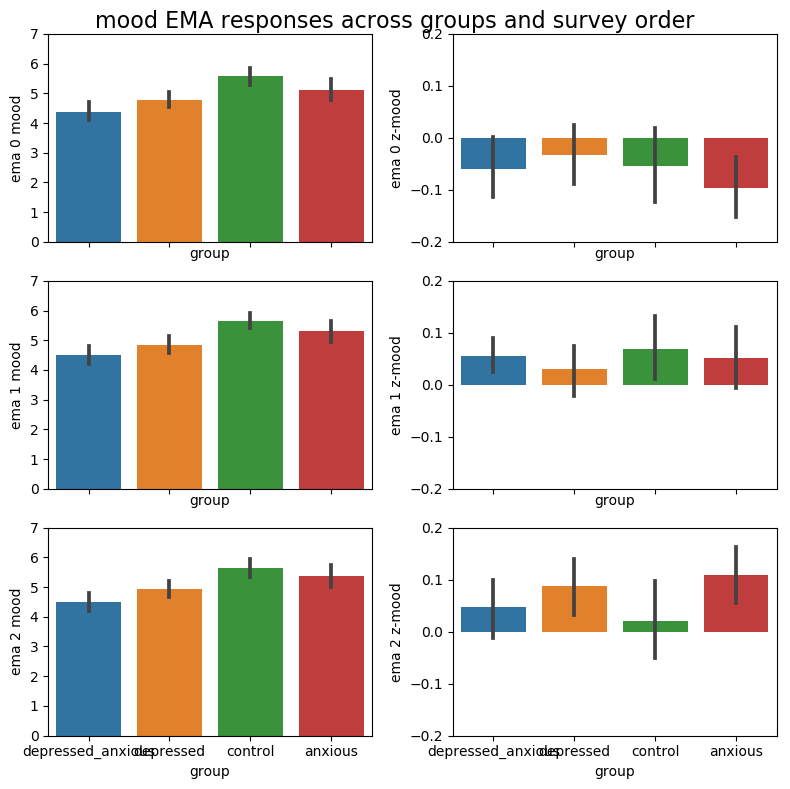

In [583]:
build_emm_response_plot("mood")

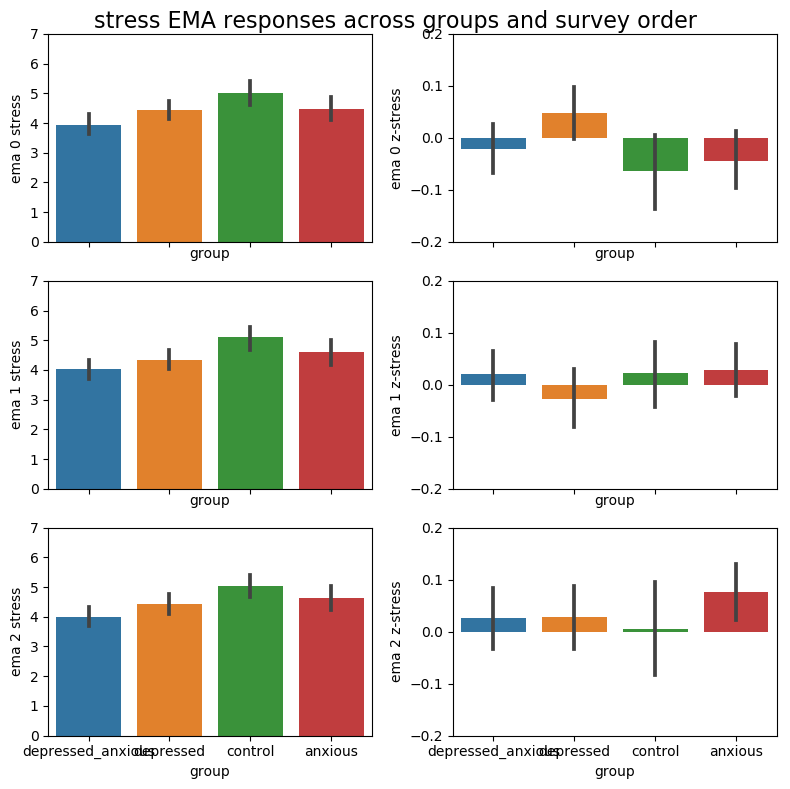

In [584]:
build_emm_response_plot('stress')

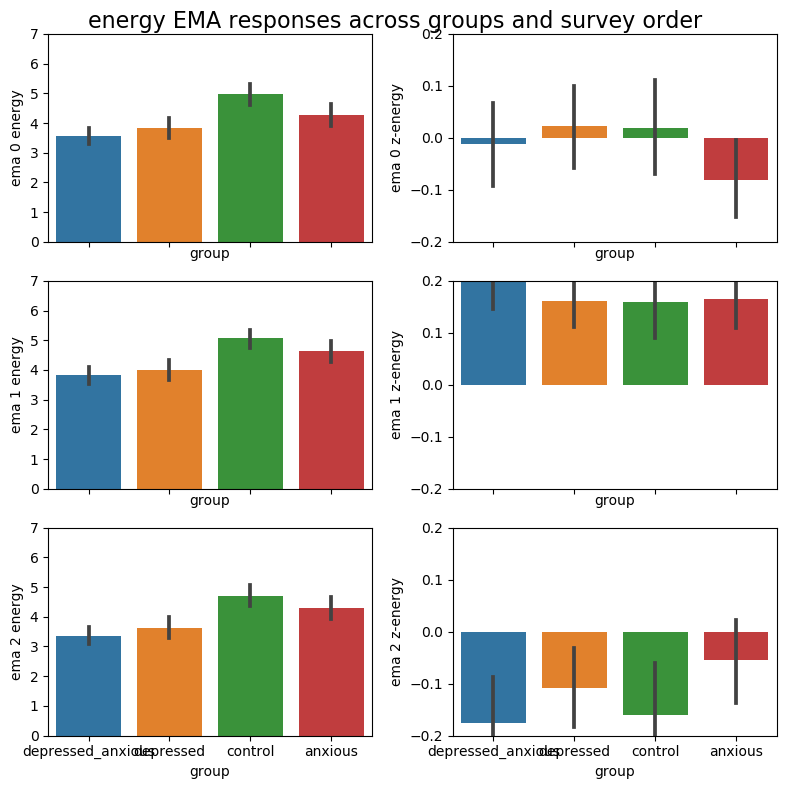

In [585]:
build_emm_response_plot('energy')

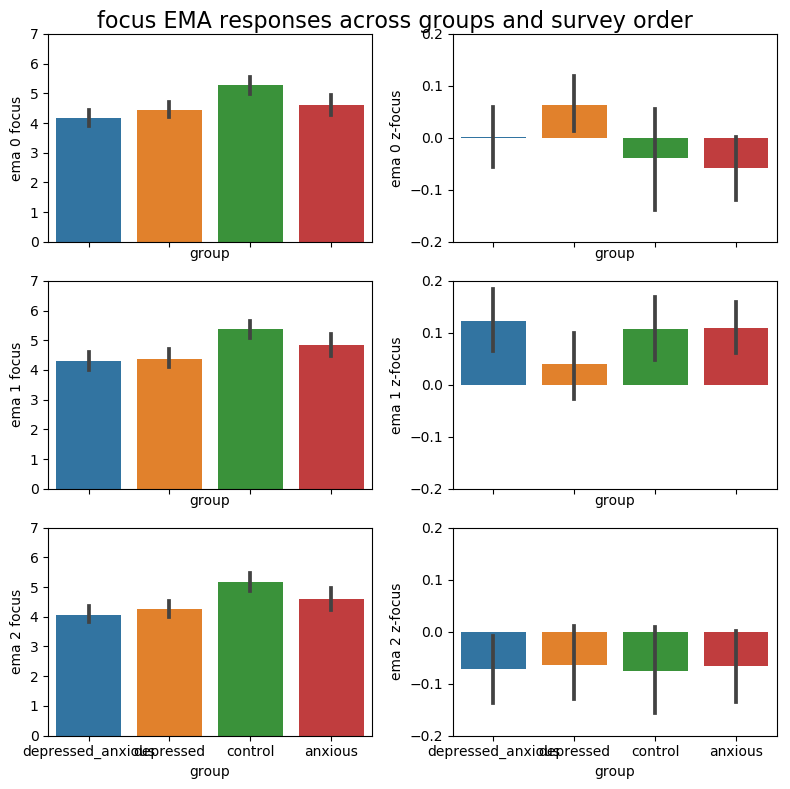

In [586]:
build_emm_response_plot('focus')

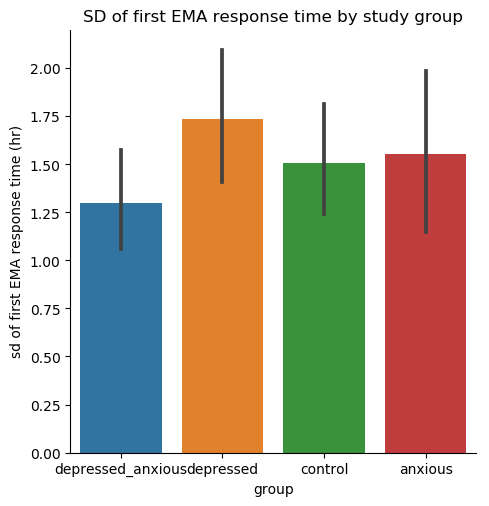

In [587]:
mpl.rcParams.update(mpl.rcParamsDefault)

sns.catplot(x='group', 
            y='0_std_emm', 
            data=context_df, 
            kind="bar")
plt.ylabel("sd of first EMA response time (hr)")
plt.title("SD of first EMA response time by study group")
plt.show()

### Correlations

In [404]:
context_corr_df = context_df.copy()
context_corr_df = context_corr_df.drop('group', axis='columns')
context_corr_df = context_corr_df.merge(screener_df[['pid', 'score_PHQ', 'score_GAD']], on='pid', how='left')
context_corr_df = context_corr_df.set_index('pid')

In [405]:
corrs, _, p_vals = run_r_corr(context_corr_df)

In [406]:
def build_corr_mat(corrs, p_vals, labels, title, alpha):
    """
    returns the matplotlib plt object for the specified correlations.
    """
    plt.rcParams["figure.figsize"] = [20,12]
    plt.imshow(corrs)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = "{0:.2f}".format(corrs[i, j])
            p = p_vals[i,j]
            if p < alpha:
                text = text + "*"
            plt.text(j,i, text, ha="center", va="center", color="w")
    plt.xticks([x for x in range(len(labels))], labels, rotation=45, ha="right", rotation_mode='anchor')
    plt.yticks([x for x in range(len(labels))], labels)
    plt.colorbar()
    plt.title(title)
    return plt


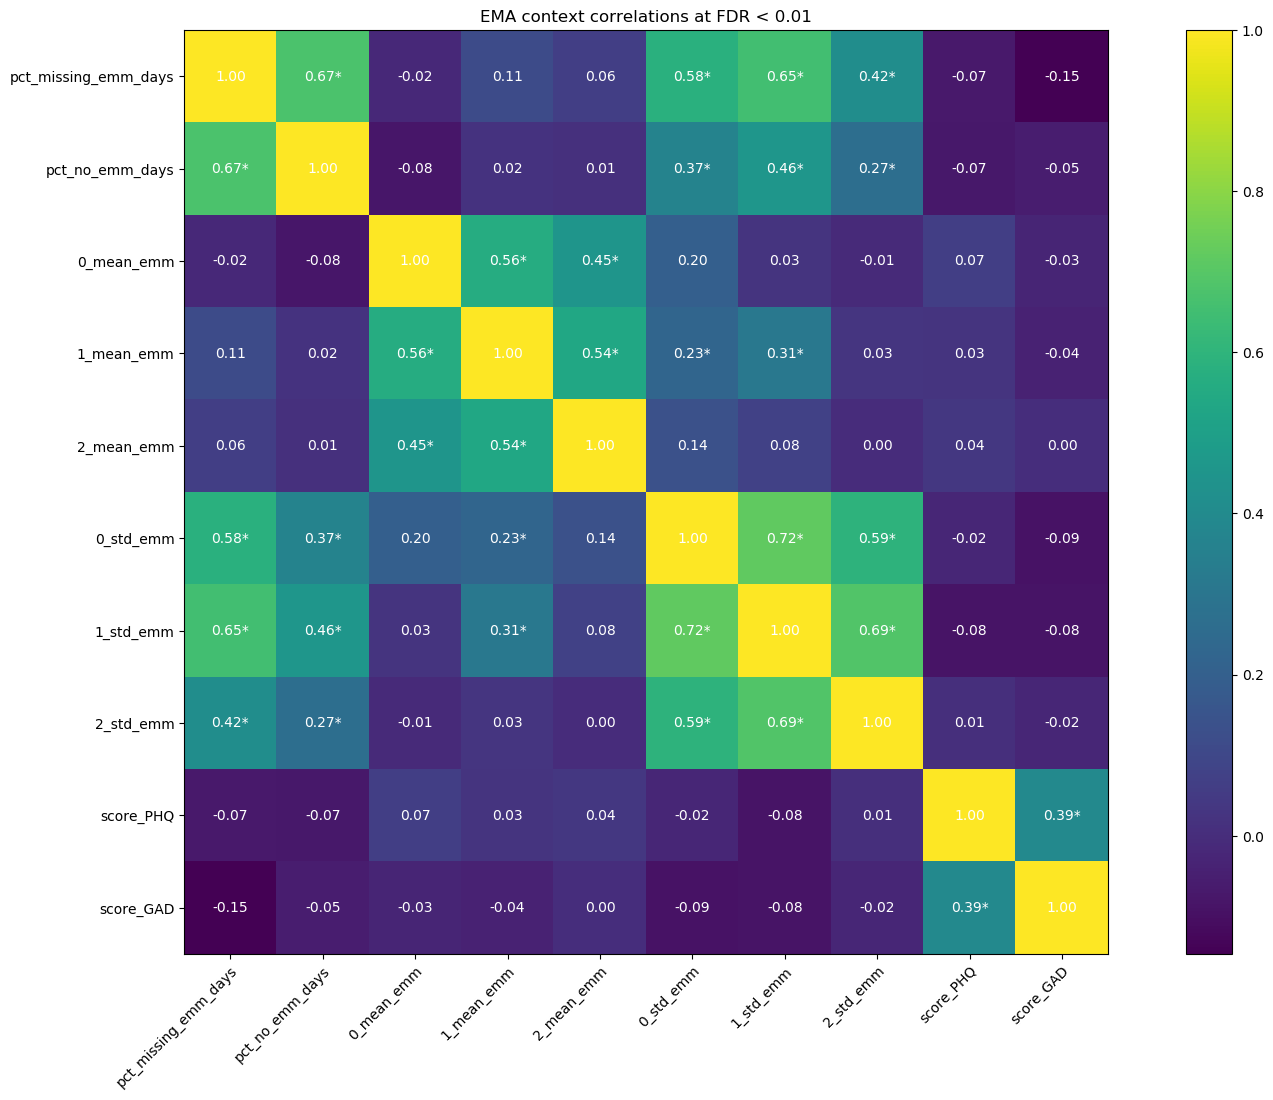

In [407]:
plt = build_corr_mat(corrs, p_vals, context_corr_df.columns.values, 'EMA context correlations at FDR < 0.01', 0.01)
# plt.rc('font', size=20)    # fontsize of the tick labels
# plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.show()

## Remarks

- significant correlations between missing EMA surveys and variability in EMA response time
- mood is worst at the first EMA response
- energy and focus is the highest at the second EMA response

### Notes

- slice out hour of EMA response to check correlation?
- want: cross reference of EMA response time with other sensors
- what predicts a day where there is a missing EMA?
    - how to set up this sequence prediction?
    
- should we standardize the EMA responses or not?

- prediction problem: given the characteristics of a day, how many EMAs did the person answer?

#### TODOs

- ~~figure out missingness of EMA responses~~
- ~~figure out missingness as a function of mood disorder group~~
- ~~ould be a good idea to group everything into those four categories~~
- ~~look at time of first response of the day~~
- ~~look into the regularity of EMA responses (variance in gaps)~~
    - ~~(better?) variance in hour of day~~
- ~~correlations between which EMA response and mean survey responses~~
- ~~get list of days with missing EMA responses~~
    - n~~eed to somehow check days with 0 EMA responses~~
- ~~look at completely missing days~~